In [4]:
import argparse
import os

import numpy as np
import pandas as pd
from numpy.random.mtrand import RandomState
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, GroupShuffleSplit, StratifiedShuffleSplit, StratifiedGroupKFold
from pathlib import Path


In [5]:
from natsort import natsorted

In [6]:
import sys

In [13]:
data_dir = '../data'
df = []

phase = ['public', 'warmup', 'private']

for phase in phase:
    if phase == "private":
        splits = ["test"]
    elif phase == "warmup":
        splits = ["train", "valid"]
    else:
        splits = ['train', 'valid', 'test']
        
    for split in splits:
        img_dir = os.path.join(data_dir, phase, "img", split)
        img_list = natsorted(os.listdir(img_dir))
        ann_dir = os.path.join(data_dir, phase, "ann", split)
        
        for filename in img_list:
            img_path = os.path.join(img_dir, filename)
            assert os.path.exists(img_path), f"{img_path} does not exist"

            ann_path = os.path.join(ann_dir, f"{Path(filename).stem}.png")
            assert os.path.exists(ann_path), f"{ann_path} does not exist"
            
            df.append({"img": img_path.replace('../data/', 'data/'), 
                       "ann": ann_path.replace('../data/', 'data/'), 
                       "phase": phase, 
                       "split": split})
            

In [14]:
df = pd.DataFrame(df)
df

img  \
0     data/public/img/train/0a0e0c6fa16fe04faa5564fb...   
1     data/public/img/train/0a15d53535f213c058a7ee9b...   
2     data/public/img/train/0a33a7b7928d7fc811e01ed7...   
3     data/public/img/train/0a35cfbfbc9bc7a99d1946e0...   
4     data/public/img/train/0a37b171afac1b1b71e7818f...   
...                                                 ...   
6807  data/private/img/test/fe2d29826912e1bc1aa753a4...   
6808  data/private/img/test/fe2fb2a5f7f6dee95801079c...   
6809  data/private/img/test/fed14c87dbb8034520dd220f...   
6810  data/private/img/test/ff760897b091bf3a55ccb8dd...   
6811  data/private/img/test/ffe0a98758035e752c167ad3...   

                                                    ann    phase  split  
0     data/public/ann/train/0a0e0c6fa16fe04faa5564fb...   public  train  
1     data/public/ann/train/0a15d53535f213c058a7ee9b...   public  train  
2     data/public/ann/train/0a33a7b7928d7fc811e01ed7...   public  train  
3     data/public/ann/train/0a35cfbfbc9bc7a99d1946e0...   public  train  
4     data/public/ann/train/0a37b171afac1b1b71e7818f...   public  train  
...                                                 ...      ...    ...  
6807  data/private/ann/test/fe2d29826912e1bc1aa753a4...  private   test  
6808  data/private/ann/test/fe2fb2a5f7f6dee95801079c...  private   test  
6809  data/private/ann/test/fed14c87dbb8034520dd220f...  private   test  
6810  data/private/ann/test/ff760897b091bf3a55ccb8dd...  private   test  
6811  data/private/ann/test/ffe0a98758035e752c167ad3...  private   test  

[6812 rows x 4 columns]

In [15]:
df[df["phase"] == "public"]['split'].value_counts()

split
train    4322
valid     689
test      682
Name: count, dtype: int64

In [16]:
df[df["phase"] == "private"]['split'].value_counts()


split
test    783
Name: count, dtype: int64

In [17]:
df[df["phase"] == "warmup"]['split'].value_counts()

split
train    225
valid    111
Name: count, dtype: int64

In [18]:
import sys
from pathlib import Path
from pkg.utils import mask_to_rle, show_in_grid, mask_to_rgb
from PIL import Image
import random
import os

In [19]:
ROOT_DIR = Path(os.path.abspath("../"))

In [20]:
df[(df["phase"] == "public") & (df["split"] == "test")]

img  \
5011  data/public/img/test/0a2fc3d2435d17679aaa3517c...   
5012  data/public/img/test/0a3f87311034518e0d70f39ed...   
5013  data/public/img/test/0ad09d78f50cb8f0c37fcca06...   
5014  data/public/img/test/0adbec6ce95d0b08aeb14531b...   
5015  data/public/img/test/0b2ac2b6470410c403e439a46...   
...                                                 ...   
5688  data/public/img/test/fe818bb1de1fea63597c397b0...   
5689  data/public/img/test/febdb45381f8880812aba1770...   
5690  data/public/img/test/fed668c7843b3fea37561c00b...   
5691  data/public/img/test/ff01cb2169e261c9bf7ff5438...   
5692  data/public/img/test/ff491605f23f7b4723fe4754c...   

                                                    ann   phase split  
5011  data/public/ann/test/0a2fc3d2435d17679aaa3517c...  public  test  
5012  data/public/ann/test/0a3f87311034518e0d70f39ed...  public  test  
5013  data/public/ann/test/0ad09d78f50cb8f0c37fcca06...  public  test  
5014  data/public/ann/test/0adbec6ce95d0b08aeb14531b...  public  test  
5015  data/public/ann/test/0b2ac2b6470410c403e439a46...  public  test  
...                                                 ...     ...   ...  
5688  data/public/ann/test/fe818bb1de1fea63597c397b0...  public  test  
5689  data/public/ann/test/febdb45381f8880812aba1770...  public  test  
5690  data/public/ann/test/fed668c7843b3fea37561c00b...  public  test  
5691  data/public/ann/test/ff01cb2169e261c9bf7ff5438...  public  test  
5692  data/public/ann/test/ff491605f23f7b4723fe4754c...  public  test  

[682 rows x 4 columns]

In [22]:
imgs = []
anns = []
NUM_IMGS = 5
for i, row in df[(df["phase"] == "public") & (df["split"] == "test")].sample(NUM_IMGS).iterrows():
    img_path = Path(ROOT_DIR, row["img"])
    ann_path = Path(ROOT_DIR, row["ann"])
    imgs.append(img_path)
    anns.append(ann_path)
len(imgs), len(anns)

(5, 5)

In [23]:
imgs = [Image.open(img) for img in imgs]
anns = [mask_to_rgb(Image.open(ann), {1: [55, 125, 34]}) for ann in anns] # convert label 1 to green (55, 125, 34)
imgs.extend(anns)

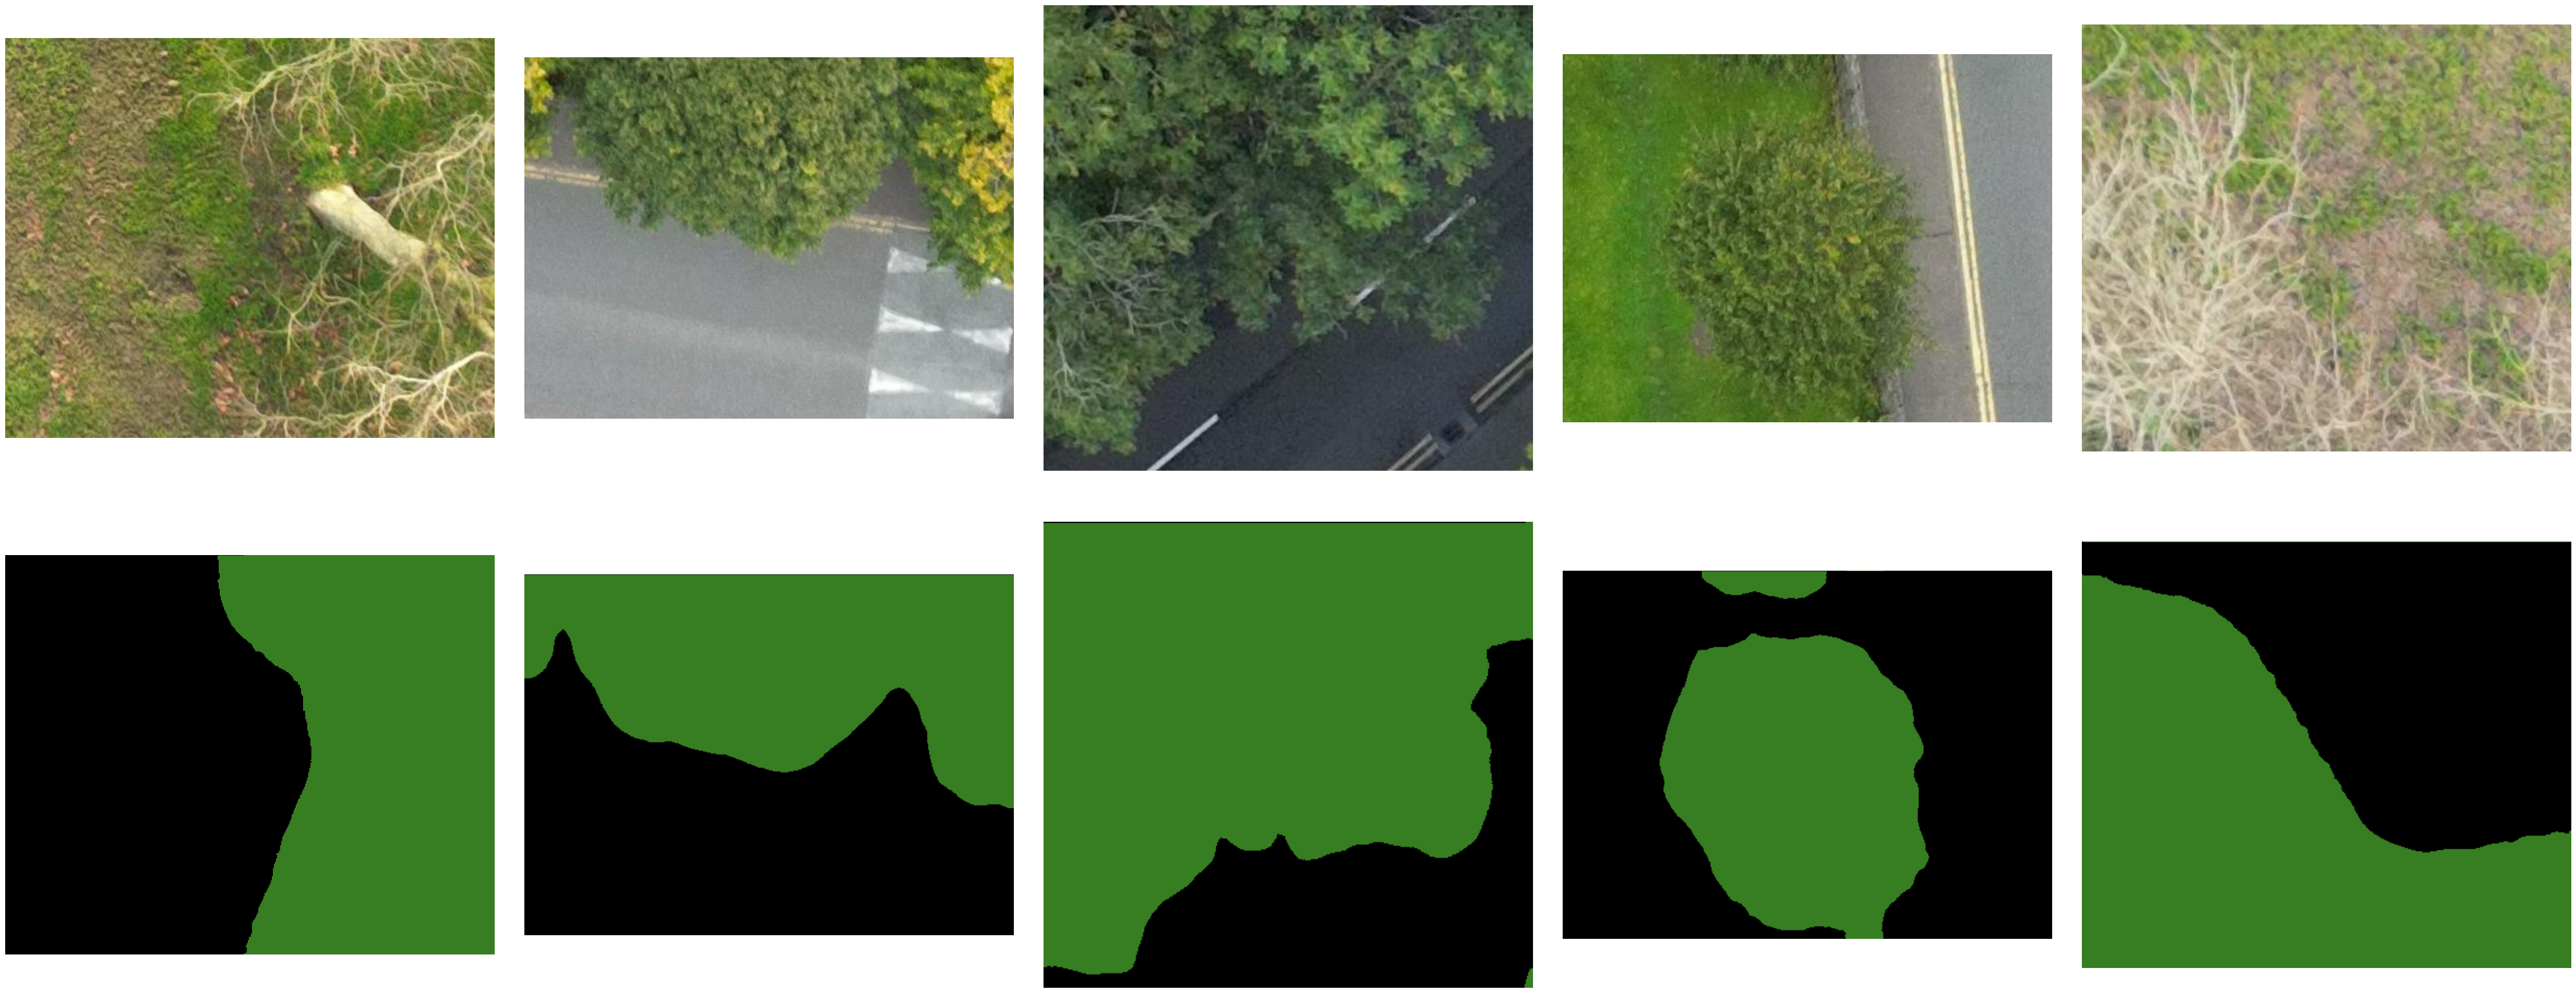

In [24]:
show_in_grid(imgs, num_rows=2, num_cols=int(len(imgs) / 2), show_plot=True)


In [53]:
# # calculate num_folds based on train/val proportion
# num_train = len(df[df["split"] == "train"])
# num_val = len(df[df["split"] == "valid"])
# print(f"num_train: {num_train}, num_val: {num_val}")
# num_folds = int(num_train / num_val)
# num_folds

num_train: 4547, num_val: 800


5

In [27]:
num_folds = 5

In [28]:
# create stratified folds on split and phase
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
df["fold"] = -1
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df["split"] + df["phase"])):
    df.loc[val_idx, "fold"] = fold
    


In [29]:
df

img  \
0     data/public/img/train/0a0e0c6fa16fe04faa5564fb...   
1     data/public/img/train/0a15d53535f213c058a7ee9b...   
2     data/public/img/train/0a33a7b7928d7fc811e01ed7...   
3     data/public/img/train/0a35cfbfbc9bc7a99d1946e0...   
4     data/public/img/train/0a37b171afac1b1b71e7818f...   
...                                                 ...   
6807  data/private/img/test/fe2d29826912e1bc1aa753a4...   
6808  data/private/img/test/fe2fb2a5f7f6dee95801079c...   
6809  data/private/img/test/fed14c87dbb8034520dd220f...   
6810  data/private/img/test/ff760897b091bf3a55ccb8dd...   
6811  data/private/img/test/ffe0a98758035e752c167ad3...   

                                                    ann    phase  split  fold  
0     data/public/ann/train/0a0e0c6fa16fe04faa5564fb...   public  train     1  
1     data/public/ann/train/0a15d53535f213c058a7ee9b...   public  train     0  
2     data/public/ann/train/0a33a7b7928d7fc811e01ed7...   public  train     1  
3     data/public/ann/train/0a35cfbfbc9bc7a99d1946e0...   public  train     3  
4     data/public/ann/train/0a37b171afac1b1b71e7818f...   public  train     2  
...                                                 ...      ...    ...   ...  
6807  data/private/ann/test/fe2d29826912e1bc1aa753a4...  private   test     3  
6808  data/private/ann/test/fe2fb2a5f7f6dee95801079c...  private   test     3  
6809  data/private/ann/test/fed14c87dbb8034520dd220f...  private   test     2  
6810  data/private/ann/test/ff760897b091bf3a55ccb8dd...  private   test     3  
6811  data/private/ann/test/ffe0a98758035e752c167ad3...  private   test     2  

[6812 rows x 5 columns]

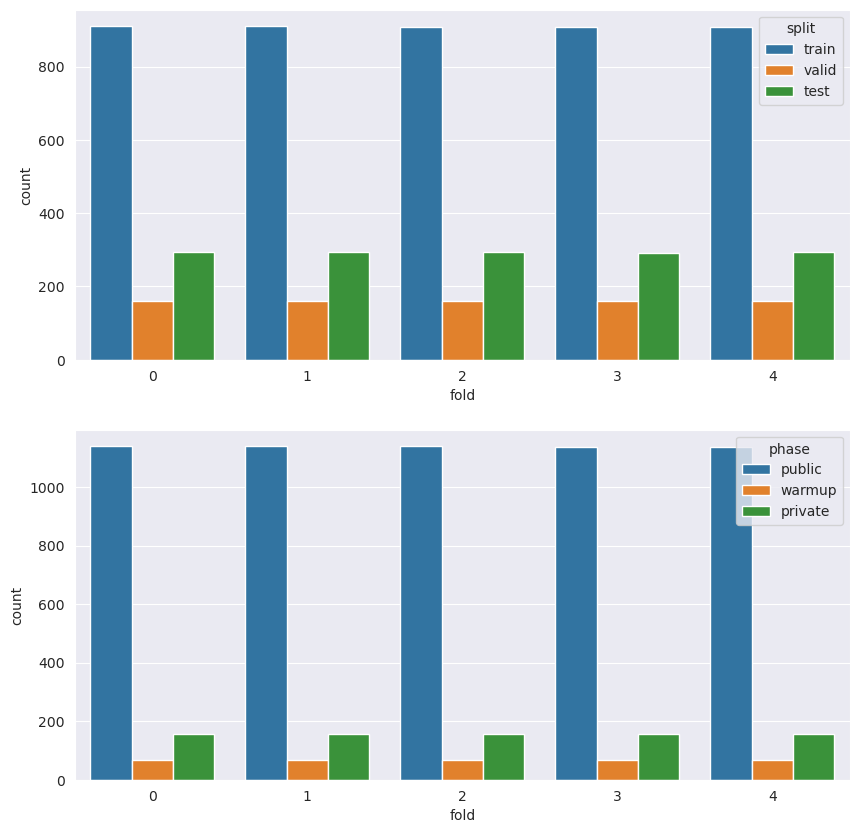

In [30]:
# plot distribution of folds across splits and phases
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
sns.countplot(x="fold", hue="split", data=df)

plt.subplot(2, 1, 2)
sns.countplot(x="fold", hue="phase", data=df)

plt.show()

In [31]:
df.to_csv("../data/df_pseudo.csv", index=False)

In [32]:
for fold in range(num_folds):
    print(f"Fold {fold}")
    for split in ["train", "valid"]:
        print(f"Split {split}")
        if split == "train":
            data_df = df[df["fold"] != fold]
            print(len(data_df))
        else:
            data_df = df[df["fold"] == fold]
            print(len(data_df))
        

Fold 0
Split train
5449
Split valid
1363
Fold 1
Split train
5449
Split valid
1363
Fold 2
Split train
5450
Split valid
1362
Fold 3
Split train
5450
Split valid
1362
Fold 4
Split train
5450
Split valid
1362


## Image sizes stats

In [33]:
import pandas as pd

In [34]:
import os
os.chdir('..')

In [35]:
df = pd.read_csv("data/df_pseudo.csv")


In [36]:
df

img  \
0     data/public/img/train/0a0e0c6fa16fe04faa5564fb...   
1     data/public/img/train/0a15d53535f213c058a7ee9b...   
2     data/public/img/train/0a33a7b7928d7fc811e01ed7...   
3     data/public/img/train/0a35cfbfbc9bc7a99d1946e0...   
4     data/public/img/train/0a37b171afac1b1b71e7818f...   
...                                                 ...   
6807  data/private/img/test/fe2d29826912e1bc1aa753a4...   
6808  data/private/img/test/fe2fb2a5f7f6dee95801079c...   
6809  data/private/img/test/fed14c87dbb8034520dd220f...   
6810  data/private/img/test/ff760897b091bf3a55ccb8dd...   
6811  data/private/img/test/ffe0a98758035e752c167ad3...   

                                                    ann    phase  split  fold  
0     data/public/ann/train/0a0e0c6fa16fe04faa5564fb...   public  train     1  
1     data/public/ann/train/0a15d53535f213c058a7ee9b...   public  train     0  
2     data/public/ann/train/0a33a7b7928d7fc811e01ed7...   public  train     1  
3     data/public/ann/train/0a35cfbfbc9bc7a99d1946e0...   public  train     3  
4     data/public/ann/train/0a37b171afac1b1b71e7818f...   public  train     2  
...                                                 ...      ...    ...   ...  
6807  data/private/ann/test/fe2d29826912e1bc1aa753a4...  private   test     3  
6808  data/private/ann/test/fe2fb2a5f7f6dee95801079c...  private   test     3  
6809  data/private/ann/test/fed14c87dbb8034520dd220f...  private   test     2  
6810  data/private/ann/test/ff760897b091bf3a55ccb8dd...  private   test     3  
6811  data/private/ann/test/ffe0a98758035e752c167ad3...  private   test     2  

[6812 rows x 5 columns]

In [37]:
df[df["phase"] == "public"]['split'].value_counts()

split
train    4322
valid     689
test      682
Name: count, dtype: int64

In [38]:
df[df["phase"] == "private"]['split'].value_counts()

split
test    783
Name: count, dtype: int64

In [39]:
df[df["phase"] == "warmup"]['split'].value_counts()

split
train    225
valid    111
Name: count, dtype: int64

In [40]:
import cv2 
import numpy as np

In [41]:
def get_img_size(img_path):
    img = cv2.imread(img_path)
    return img.shape[:2]


In [42]:
df["img_size"] = df["img"].apply(get_img_size)

In [43]:
df

img  \
0     data/public/img/train/0a0e0c6fa16fe04faa5564fb...   
1     data/public/img/train/0a15d53535f213c058a7ee9b...   
2     data/public/img/train/0a33a7b7928d7fc811e01ed7...   
3     data/public/img/train/0a35cfbfbc9bc7a99d1946e0...   
4     data/public/img/train/0a37b171afac1b1b71e7818f...   
...                                                 ...   
6807  data/private/img/test/fe2d29826912e1bc1aa753a4...   
6808  data/private/img/test/fe2fb2a5f7f6dee95801079c...   
6809  data/private/img/test/fed14c87dbb8034520dd220f...   
6810  data/private/img/test/ff760897b091bf3a55ccb8dd...   
6811  data/private/img/test/ffe0a98758035e752c167ad3...   

                                                    ann    phase  split  fold  \
0     data/public/ann/train/0a0e0c6fa16fe04faa5564fb...   public  train     1   
1     data/public/ann/train/0a15d53535f213c058a7ee9b...   public  train     0   
2     data/public/ann/train/0a33a7b7928d7fc811e01ed7...   public  train     1   
3     data/public/ann/train/0a35cfbfbc9bc7a99d1946e0...   public  train     3   
4     data/public/ann/train/0a37b171afac1b1b71e7818f...   public  train     2   
...                                                 ...      ...    ...   ...   
6807  data/private/ann/test/fe2d29826912e1bc1aa753a4...  private   test     3   
6808  data/private/ann/test/fe2fb2a5f7f6dee95801079c...  private   test     3   
6809  data/private/ann/test/fed14c87dbb8034520dd220f...  private   test     2   
6810  data/private/ann/test/ff760897b091bf3a55ccb8dd...  private   test     3   
6811  data/private/ann/test/ffe0a98758035e752c167ad3...  private   test     2   

        img_size  
0     (384, 427)  
1     (384, 467)  
2     (384, 423)  
3     (384, 498)  
4     (384, 507)  
...          ...  
6807  (384, 467)  
6808  (385, 488)  
6809  (384, 464)  
6810  (384, 430)  
6811  (384, 384)  

[6812 rows x 6 columns]

In [44]:
df['min_size'] = df['img_size'].apply(lambda x: min(x))
df['max_size'] = df['img_size'].apply(lambda x: max(x))
df['ratio'] = df['img_size'].apply(lambda x: x[0] / x[1])

In [45]:
df

img  \
0     data/public/img/train/0a0e0c6fa16fe04faa5564fb...   
1     data/public/img/train/0a15d53535f213c058a7ee9b...   
2     data/public/img/train/0a33a7b7928d7fc811e01ed7...   
3     data/public/img/train/0a35cfbfbc9bc7a99d1946e0...   
4     data/public/img/train/0a37b171afac1b1b71e7818f...   
...                                                 ...   
6807  data/private/img/test/fe2d29826912e1bc1aa753a4...   
6808  data/private/img/test/fe2fb2a5f7f6dee95801079c...   
6809  data/private/img/test/fed14c87dbb8034520dd220f...   
6810  data/private/img/test/ff760897b091bf3a55ccb8dd...   
6811  data/private/img/test/ffe0a98758035e752c167ad3...   

                                                    ann    phase  split  fold  \
0     data/public/ann/train/0a0e0c6fa16fe04faa5564fb...   public  train     1   
1     data/public/ann/train/0a15d53535f213c058a7ee9b...   public  train     0   
2     data/public/ann/train/0a33a7b7928d7fc811e01ed7...   public  train     1   
3     data/public/ann/train/0a35cfbfbc9bc7a99d1946e0...   public  train     3   
4     data/public/ann/train/0a37b171afac1b1b71e7818f...   public  train     2   
...                                                 ...      ...    ...   ...   
6807  data/private/ann/test/fe2d29826912e1bc1aa753a4...  private   test     3   
6808  data/private/ann/test/fe2fb2a5f7f6dee95801079c...  private   test     3   
6809  data/private/ann/test/fed14c87dbb8034520dd220f...  private   test     2   
6810  data/private/ann/test/ff760897b091bf3a55ccb8dd...  private   test     3   
6811  data/private/ann/test/ffe0a98758035e752c167ad3...  private   test     2   

        img_size  min_size  max_size     ratio  
0     (384, 427)       384       427  0.899297  
1     (384, 467)       384       467  0.822270  
2     (384, 423)       384       423  0.907801  
3     (384, 498)       384       498  0.771084  
4     (384, 507)       384       507  0.757396  
...          ...       ...       ...       ...  
6807  (384, 467)       384       467  0.822270  
6808  (385, 488)       385       488  0.788934  
6809  (384, 464)       384       464  0.827586  
6810  (384, 430)       384       430  0.893023  
6811  (384, 384)       384       384  1.000000  

[6812 rows x 9 columns]

In [46]:
df.describe()

fold     min_size     max_size        ratio
count  6812.000000  6812.000000  6812.000000  6812.000000
mean      1.999560   384.053876   489.008514     0.807546
std       1.414369     0.231567    89.155001     0.125238
min       0.000000   383.000000   384.000000     0.318144
25%       1.000000   384.000000   424.000000     0.720450
50%       2.000000   384.000000   467.000000     0.822270
75%       3.000000   384.000000   533.000000     0.905660
max       4.000000   385.000000  1207.000000     1.000000